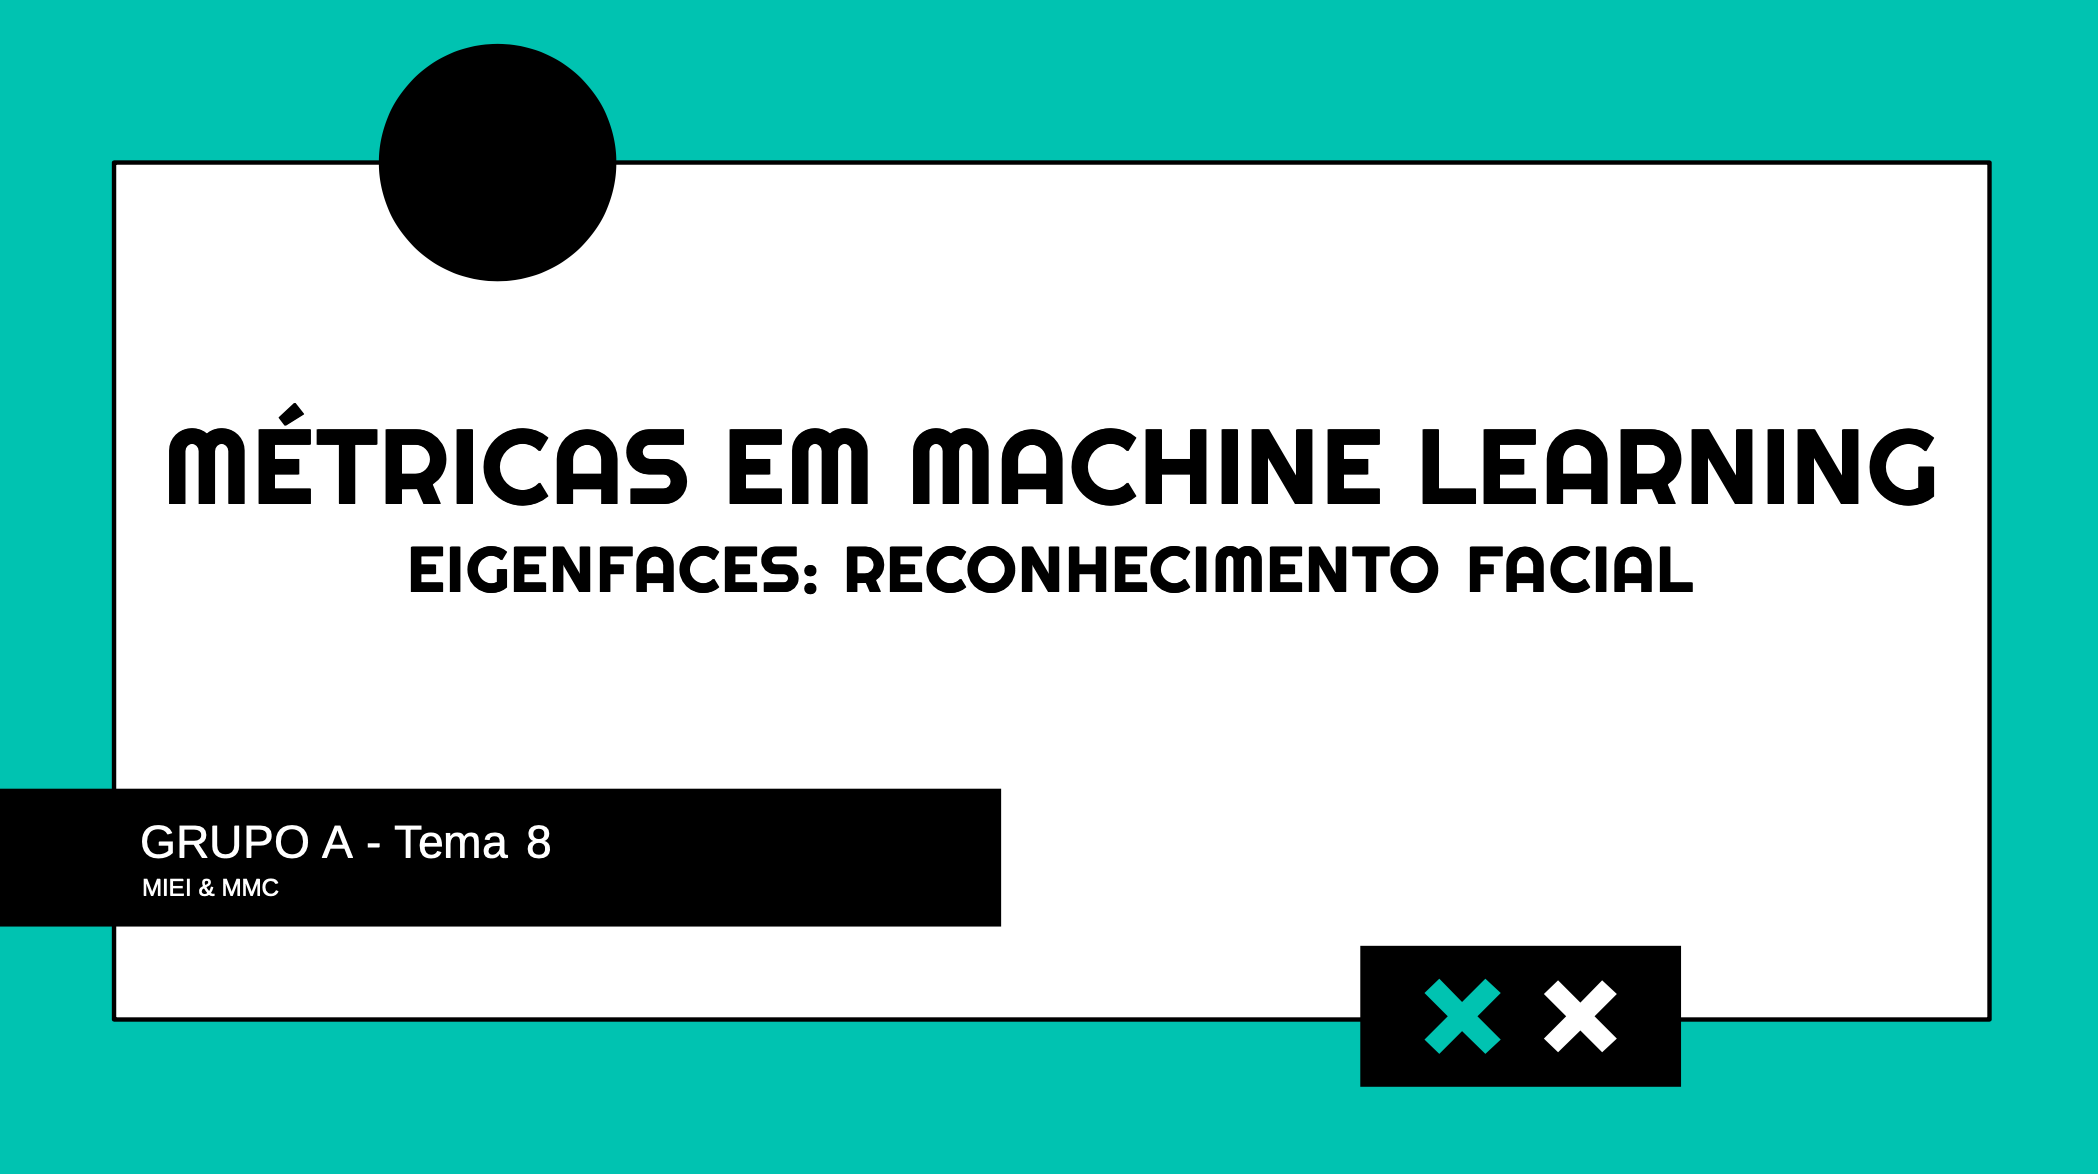

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

### Leitura das imagens de treino

* f é para usar as chavetas { } na string

* convert('L') é para tornas as fotografias greyscale (monocromático)

In [2]:
import glob
images = [glob.glob('OurDataBase/{}/*'.format(pasta)) for pasta in ['Cristina', 'Maria', 'Matilde', 'Pedro']]

In [3]:
base = [Image.open(img).convert('L') for pasta in images for img in pasta]

#### "Chama" a imagem

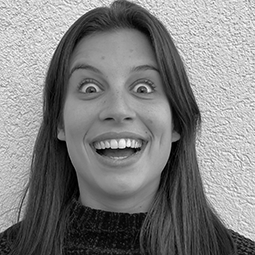

In [4]:
input_img = Image.open(f'OurDataBase/Matilde/9.png').convert('L')
input_img

#### Saber a quantidade de fotografias que existem

In [5]:
M = len(base)
M

36

#### Gera uma lista de listas em que cada lista corresponde a uma imagem (0 a 399)

In [6]:
X = np.array([base[i].getdata() for i in range(M)])

#### Temos 36 listas em que cada uma 65025 elementos

In [7]:
print(X.shape)
X

(36, 65025)


array([[226, 201, 219, ...,  88,  86,  87],
       [219, 207, 203, ...,  79,  80,  80],
       [239, 208, 205, ...,  83,  86,  84],
       ...,
       [207, 230, 222, ...,  45,  46,  46],
       [206, 218, 237, ...,  40,  44,  41],
       [200, 197, 211, ...,  42,  40,  40]])

### Centrar o X à média

In [8]:
media = np.mean(X, 0)
phi = X - media

In [9]:
media

array([209.33333333, 203.36111111, 203.63888889, ...,  75.52777778,
        78.        ,  76.30555556])

Tamanho da matriz, será uma matriz 36$\times$65025:

In [10]:
phi.shape

(36, 65025)

### Matriz Covariância

* e_faces : vetores singulares
* sigma : valores singulares
* Não vamos usar o v pelo que metemos como "_"

In [11]:
e_faces, sigma, _ = np.linalg.svd(phi.transpose(), full_matrices = False)

In [12]:
#matrix_Cov = np.cov(phi)
#matrix_Cov

### Cálculo dos valores próprios

#### Os valores singulares são a raiz de um valor próprio, logo:

In [13]:
val_prop = sigma*sigma

#### Ordenar os valores próprios de forma decrescente

In [14]:
val_prop = np.sort(val_prop)
# o sort dá a lista ordenada crescentemente
# queremos decrescentemente, daí o ::-1
val_prop = val_prop[::-1]

#### Traço da matriz de dispersão (soma de todos valores próprios)

In [15]:
traco = sum(val_prop)

### Componentes Principais - Elbow Plot

#### Calcular o $k$ consoante a confiança da soma dos $k$ primeiros valores próprios.
* parar quando temos uma confiança mínima de 80%;
* parar quando começar a incrementar menos de 0.5% na confiança.

In [16]:
confianca_alvo = 0.80
k = 0
confianca = 0
confiancaAnt = 0

while k < 5:
    confiancaAnt = confianca
    confianca = confianca + val_prop[k]/traco
    k += 1
    
    print('(confiança, valor próprio): ({0}, {1})'.format(confianca, k))
        
k, confianca

(confiança, valor próprio): (0.36213901828270145, 1)
(confiança, valor próprio): (0.5057718163634682, 2)
(confiança, valor próprio): (0.6186712938244187, 3)
(confiança, valor próprio): (0.664529764283546, 4)
(confiança, valor próprio): (0.7020539134739743, 5)


(5, 0.7020539134739743)

A escolha do $k$ baseou-se ????

Localização do $k$ no elbow plot (método do cotovelo)

In [17]:
k = 5

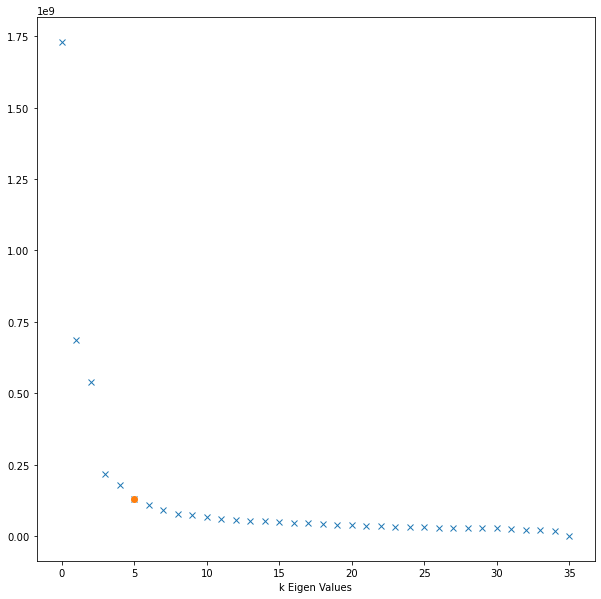

In [18]:
plt.figure(figsize = (10, 10))
t = np.arange(0, M, 1)
plt.plot(t, val_prop, 'x')
plt.plot(k, val_prop[k], 'o')
plt.xlabel('k Eigen Values')
#plt.savefig('elbow.pdf', format = 'pdf')
plt.show()

#### Cálculo dos $k$ primeiros vetores próprios

In [19]:
newE_Faces = e_faces[:, 0:k]

In [20]:
phi.shape

(36, 65025)

In [21]:
newE_Faces.shape

(65025, 5)

### Projeção dos dados

In [22]:
coef_proj = [np.dot(phi[i], newE_Faces) for i in range(M)]

#### Aplicação:

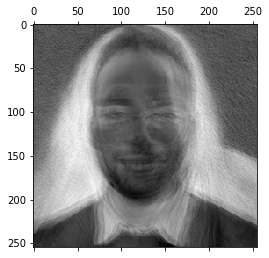

In [23]:
display(plt.matshow(np.reshape(newE_Faces.T[0], (255, 255)), cmap = 'gray'))

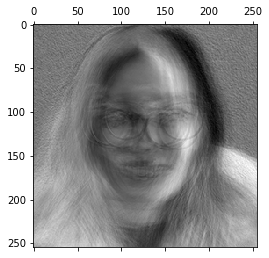

In [24]:
display(plt.matshow(np.reshape(newE_Faces.T[1], (255, 255)), cmap = 'gray'))

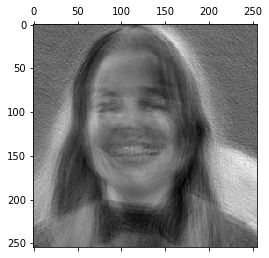

In [25]:
display(plt.matshow(np.reshape(newE_Faces.T[2], (255, 255)), cmap = 'gray'))

In [26]:
#display(plt.matshow(np.reshape(newE_Faces.T[3], (255, 255)), cmap = 'gray'))

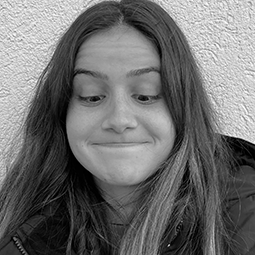

In [27]:
input_img = Image.open(f'OurDataBase/2.png').convert('L')
input_img

### Distância Euclidiana

In [28]:
def euclidian(coef_proj, test_coef_proj, M):
    dist = [np.linalg.norm(coef_proj[i] - test_coef_proj) for i in range(M)]
    return dist

### Distância Mahalanobis

In [29]:
def mahalanobis(coef_proj, test_coef_proj, val_prop, M):
    dist = [np.sum(np.divide(pow(coef_proj[i] - test_coef_proj, 2), val_prop)) for i in range(M)]
    return dist

### Reconhecimento facial

#### A função $\textit{recognition}$ indica se o reconhecimento é efetuado com sucesso ou se este falha consoante a distância mínima entre duas imagens da base de dados.

In [30]:
def recognition(dist, typeDist, limiteMaha, limiteEucli):
    d_min = np.min(dist)
    
    if typeDist == 'euclidian':
        limite = limiteEucli
    else:
        limite = limiteMaha
    
    if d_min < limite:
        # como temos 9 imagens por pasta
        pasta = int(np.floor(np.argmin(dist)/9))
        
        person =  ['Cristina', 'Maria', 'Matilde', 'Pedro'][pasta]
        
        print('Para a distância: ', typeDist)
        print('\tPessoa prevista: 'f'{person}\n\tdist = {d_min}')
        return person
    else:
        print('Falhou no reconhecimento.')
        return 'Fail'

#### A função que se segue tem como objetivo identificar uma imagem de forma mais geral.

In [31]:
def identifyImage(img, typeDist, plot, limiteMaha, limiteEucli):    
    gamma = np.array(img.getdata())
    test_phi = gamma - media
    test_coef_proj = np.dot(test_phi, newE_Faces)
    
    if typeDist == 'euclidian':
        dist = euclidian(coef_proj, test_coef_proj, M)
    elif typeDist == 'mahalanobis':
        dist = mahalanobis(coef_proj, test_coef_proj, val_prop[:k], M)
    else:
        print('Something went wrong :(')
        return -1
    
    if plot == True:
        return test_coef_proj[0:2]
    else:
        return recognition(dist, typeDist, limiteMaha, limiteEucli) 

#### Comparação da localização do indivíduo de teste (triângulo) em relação aos de treino

Text(0, 0.5, 'Eigenface 2')

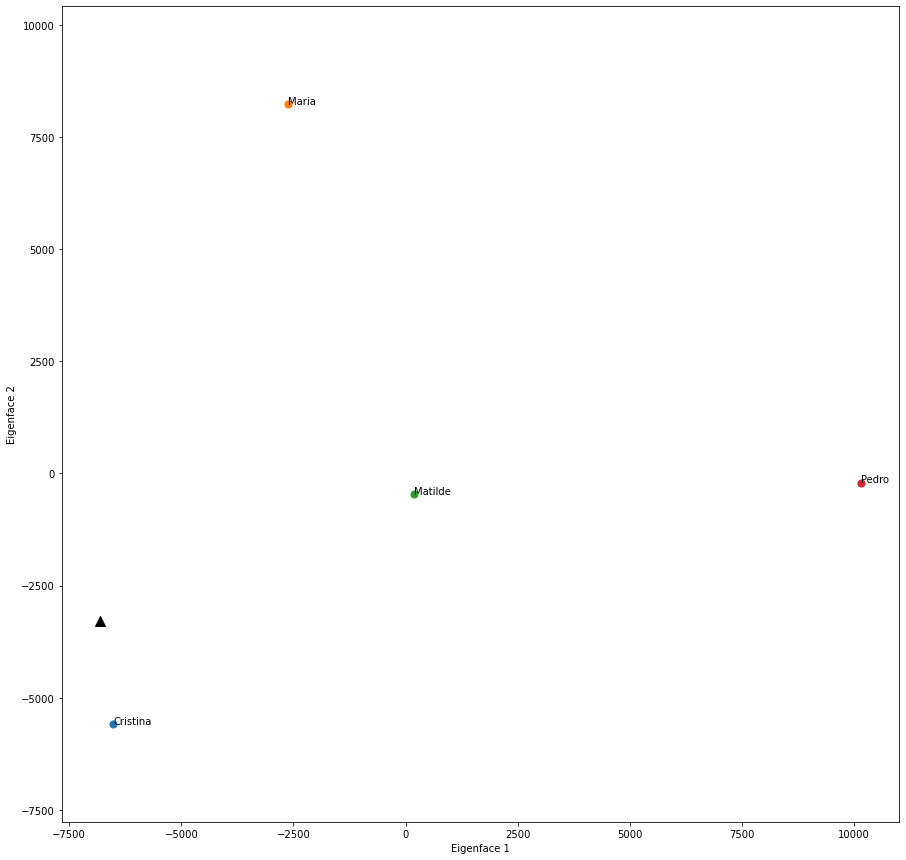

In [32]:
plt.figure(figsize = (15, 15))
plt.axis('equal')

for pasta in ['Cristina', 'Maria', 'Matilde', 'Pedro']:
    imagens = [Image.open(f'OurDataBase/{pasta}/{i}.png').convert('L') for i in range(7, 8)]
    x, y = np.array([identifyImage(pic, 'euclidian', True, 0.03, 3200) for pic in imagens]).T
    plt.scatter(x, y, s = 50)
    plt.text(x, y, pasta)
    
plt.scatter(*identifyImage(input_img, 'euclidian', True, 0.03, 3200), label = 'Input image', marker = '^', c = 'k', s = 100)
plt.xlabel('Eigenface 1')
plt.ylabel('Eigenface 2')

#### Função que determina o score para uma determinada métrica de distância.

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

def getScore(distanceMetric, real):
    predictions = []
    
    for image in range(1, 17):
        predictions.append(identifyImage(
            Image.open(f'OurDataBase/{image}.png').convert('L'),
            distanceMetric, False, 0.03, 3200))
        
    #print(confusion_matrix(real, predictions))
    print(classification_report(real, predictions, digits = 3, zero_division = 0))

#### Identificação dos indivíduos de teste.

In [34]:
test = []

for i in range(1, 4):
    test.append('Cristina')

for i in range(4, 13):
    test.append('Maria')

for i in range(13, 15):
    test.append('Matilde')
    
test.append('Pedro')
test.append('Fail')

### Score para Mahalanobis

In [35]:
getScore('mahalanobis', test)

Para a distância:  mahalanobis
	Pessoa prevista: Cristina
	dist = 0.011331340391348681
Para a distância:  mahalanobis
	Pessoa prevista: Cristina
	dist = 0.028566705292843237
Para a distância:  mahalanobis
	Pessoa prevista: Cristina
	dist = 0.004858229766602338
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0002687748729154575
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.015937565552355506
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.007408061281627192
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0072373727542412065
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.011202916117501703
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.009893907086081838
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.010702588341335818
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0031367463082239092
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0

### Score para Euclidiana

In [36]:
getScore('euclidian', test)

Para a distância:  euclidian
	Pessoa prevista: Cristina
	dist = 1653.9412306316694
Falhou no reconhecimento.
Para a distância:  euclidian
	Pessoa prevista: Cristina
	dist = 1096.1707974866874
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 462.06398965217966
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1931.1186135598925
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1437.5628518189808
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1244.5053420902882
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1793.8550166655186
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1855.7365411362057
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1465.0556806434945
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1387.9950710325636
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1405.7689069226124
Para a distância:  euclidian
	Pessoa prevista: Matilde
	dist = 1448.9832619027309
Para a

#### Determinar o limite superior da Euclidiana

In [337]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

parameters = {
    'limiteEucl': range(2400, 3500, 50),
    'limiteMaha': [0.0]
}

combinations = list(ParameterGrid(parameters))

bestScore = 0.0
bestCombination = {}

for i in combinations:
    
    predictions = []
    
    for image in range(1, 17):
        predictions.append(identifyImage(
            Image.open(f'OurDataBase/{image}.png').convert('L'),
            'euclidian', False, i['limiteMaha'], i['limiteEucl']))
    
    if bestScore < accuracy_score(test, predictions):
        bestScore = accuracy_score(test, predictions)
        bestCombination = i

Para a distância:  euclidian
	Pessoa prevista: Cristina
	dist = 1653.9412306316694
Falhou no reconhecimento.
Para a distância:  euclidian
	Pessoa prevista: Cristina
	dist = 1096.1707974866874
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 462.06398965217966
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1931.1186135598925
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1437.5628518189808
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1244.5053420902882
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1793.8550166655186
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1855.7365411362057
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1465.0556806434945
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1387.9950710325636
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1405.7689069226124
Para a distância:  euclidian
	Pessoa prevista: Matilde
	dist = 1448.9832619027309
Para a

Falhou no reconhecimento.
Para a distância:  euclidian
	Pessoa prevista: Cristina
	dist = 1653.9412306316694
Falhou no reconhecimento.
Para a distância:  euclidian
	Pessoa prevista: Cristina
	dist = 1096.1707974866874
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 462.06398965217966
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1931.1186135598925
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1437.5628518189808
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1244.5053420902882
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1793.8550166655186
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1855.7365411362057
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1465.0556806434945
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1387.9950710325636
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1405.7689069226124
Para a distância:  euclidian
	Pessoa prevista: Matilde
	dist =

Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 462.06398965217966
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1931.1186135598925
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1437.5628518189808
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1244.5053420902882
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1793.8550166655186
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1855.7365411362057
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1465.0556806434945
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1387.9950710325636
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1405.7689069226124
Para a distância:  euclidian
	Pessoa prevista: Matilde
	dist = 1448.9832619027309
Para a distância:  euclidian
	Pessoa prevista: Matilde
	dist = 891.5908563880663
Para a distância:  euclidian
	Pessoa prevista: Pedro
	dist = 2347.6237432450216
Falhou no reconhecimento.
Para a dist

Para a distância:  euclidian
	Pessoa prevista: Cristina
	dist = 1096.1707974866874
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 462.06398965217966
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1931.1186135598925
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1437.5628518189808
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1244.5053420902882
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1793.8550166655186
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1855.7365411362057
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1465.0556806434945
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1387.9950710325636
Para a distância:  euclidian
	Pessoa prevista: Maria
	dist = 1405.7689069226124
Para a distância:  euclidian
	Pessoa prevista: Matilde
	dist = 1448.9832619027309
Para a distância:  euclidian
	Pessoa prevista: Matilde
	dist = 891.5908563880663
Para a distância:  euclidian
	Pess

In [338]:
print('\t{}\n\t{}'.format(bestCombination, bestScore))

	{'limiteEucl': 3200, 'limiteMaha': 0.0}
	1.0


#### Determinar limite superior na Mahalanobis

In [339]:
parameters = {
    'limiteEucl': [0.0],
    'limiteMaha': np.arange(0.01, 0.08, 0.005)
}

combinations = list(ParameterGrid(parameters))

bestScore = 0.0
bestCombination = {}

for i in combinations:
    
    predictions = []
    
    for image in range(1, 17):
        predictions.append(identifyImage(
            Image.open(f'OurDataBase/{image}.png').convert('L'),
            'mahalanobis', False, i['limiteMaha'], i['limiteEucl']))
    
    if bestScore < accuracy_score(test, predictions):
        bestScore = accuracy_score(test, predictions)
        bestCombination = i

Falhou no reconhecimento.
Falhou no reconhecimento.
Para a distância:  mahalanobis
	Pessoa prevista: Cristina
	dist = 0.004858229766602338
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0002687748729154575
Falhou no reconhecimento.
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.007408061281627192
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0072373727542412065
Falhou no reconhecimento.
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.009893907086081838
Falhou no reconhecimento.
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0031367463082239092
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0062180252593445045
Para a distância:  mahalanobis
	Pessoa prevista: Matilde
	dist = 0.0064595651915763256
Para a distância:  mahalanobis
	Pessoa prevista: Matilde
	dist = 0.0014705761932205577
Falhou no reconhecimento.
Falhou no reconhecimento.
Para a distância:  mahalanobis
	Pessoa prevista: 

Para a distância:  mahalanobis
	Pessoa prevista: Matilde
	dist = 0.0014705761932205577
Para a distância:  mahalanobis
	Pessoa prevista: Pedro
	dist = 0.01774380301758831
Falhou no reconhecimento.
Para a distância:  mahalanobis
	Pessoa prevista: Cristina
	dist = 0.011331340391348681
Para a distância:  mahalanobis
	Pessoa prevista: Cristina
	dist = 0.028566705292843237
Para a distância:  mahalanobis
	Pessoa prevista: Cristina
	dist = 0.004858229766602338
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0002687748729154575
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.015937565552355506
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.007408061281627192
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0072373727542412065
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.011202916117501703
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.009893907086081838
Para a distância:  mahalanobis
	Pesso

Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.04400600064109718
Para a distância:  mahalanobis
	Pessoa prevista: Cristina
	dist = 0.011331340391348681
Para a distância:  mahalanobis
	Pessoa prevista: Cristina
	dist = 0.028566705292843237
Para a distância:  mahalanobis
	Pessoa prevista: Cristina
	dist = 0.004858229766602338
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0002687748729154575
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.015937565552355506
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.007408061281627192
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0072373727542412065
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.011202916117501703
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.009893907086081838
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.010702588341335818
Para a distância:  mahalanobis
	Pessoa prevista: Maria
	dist = 0.0

In [340]:
print('\t{}\n\t{}'.format(bestCombination, bestScore))

	{'limiteEucl': 0.0, 'limiteMaha': 0.03}
	1.0


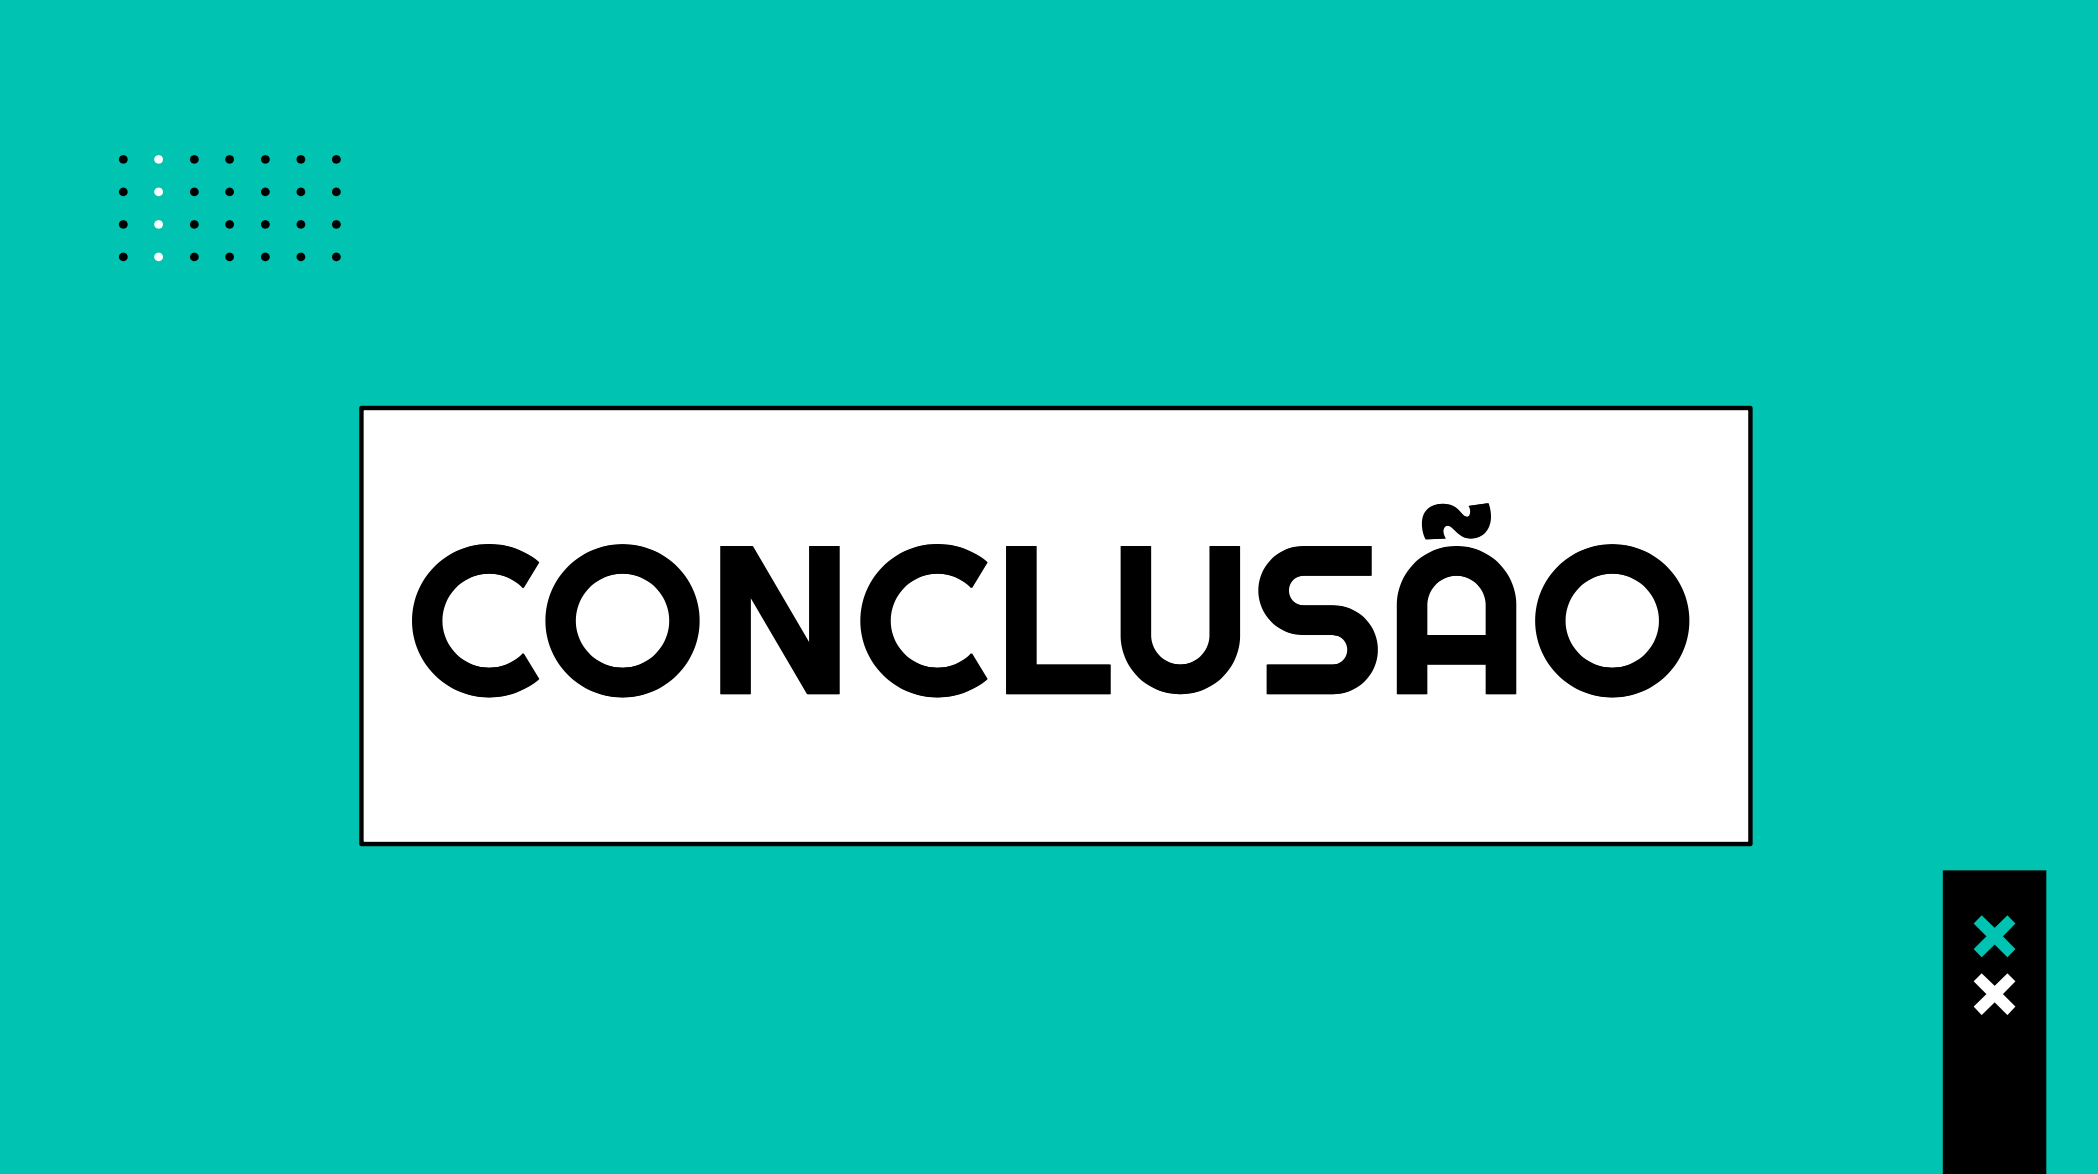